In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import gyrointerp
from numpy import random

[I 250909 14:12:11 utils:160] NumExpr defaulting to 8 threads.


In [2]:
def save_state(epoch, model, opt, loss):
    torch.save({
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": opt.state_dict(),
    "loss": loss.item(),
    }, "checkpoint.pth")

In [3]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed) 

In [4]:
teffs = np.linspace(3800, 6200, 100)
teffs_n = teffs + np.random.normal(0, 75, 100)

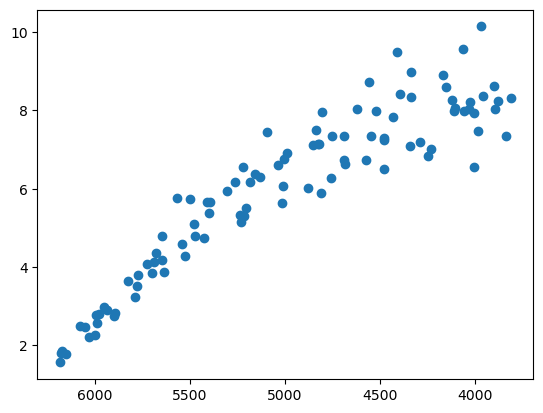

In [5]:
prots=gyrointerp.models.slow_sequence(teffs_n, 100)
prots_n=gyrointerp.models.slow_sequence(teffs_n, 100)+ np.random.normal(0, gyrointerp.models.slow_sequence(teffs_n, 100) * .1, 100)
plt.scatter(teffs_n,prots_n)
plt.gca().invert_xaxis()

In [6]:
def gyro_data(ages, teff_err=75, prot_err=0.1, nsize=100, plot=False):
    all_data = []  # to hold arrays of shape (nsize, 2) for each age

    for age in ages:
        # Generate teff and noisy teff
        teffs = np.linspace(3800, 6200, nsize)
        teffs_n = teffs + np.random.normal(0, teff_err, nsize)
        teffs_n = np.clip(teffs_n, 3800, 6200)

        # Generate rotation periods from gyro model
        prots = gyrointerp.models.slow_sequence(teffs, age)
        prots_n = gyrointerp.models.slow_sequence(teffs_n, age) + np.random.normal(
            0, gyrointerp.models.slow_sequence(teffs_n, age) * prot_err, nsize
        )

        # Optionally show scatter plot
        if plot:
            plt.scatter(teffs_n, prots_n)
            plt.gca().invert_xaxis()
            plt.title(f'Age = {age}')
            plt.xlabel('Teff (K)')
            plt.ylabel('Prot (days)')
            plt.show()

        # Stack teff and prot into shape (nsize, 2)
        data = np.column_stack((teffs_n, prots_n))
        all_data.append(data)

    return all_data, ages

# Setup

Step 1: Load the data
> right now I'm using some very basic proxy data. replace this with your own data.
> 
> I'm assuming a format of input X -> [Teff, Prot] and output y -> [age]

In [7]:
data, age  = gyro_data(np.random.uniform(100,1000,200))
#mask = (data[:, 1] > 0) & (data[:, 1] < 60) & (data[:, 0] > 3800) & (data[:, 0] < 6200)
#data_mask=data[mask]
#age_mask=age[mask]
def load_files():
    # load your csv file into a numpy array
    # make sure length of X is the same as the length of y 
    X = np.array(data)
    y = np.array(age)
    return X, y 

Step 2: Normalize the data
> Again, rewrite to fit your needs.
> 
> I recommend to ensure that your normalization worked by plotting a histogram of the normalized data. You want the distribution to range from 0.0 to 1.0 but also it should be fairly distributed.
> 
> I also recommend that you save (print out) the values you use to normalize the data (min, max, etc.). Remember that the transformation needs to be invertible. 

In [8]:
def normalize_og(x):
    # x = np.arctan(x) 
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [9]:
def normalize(x):
    x2=np.log10(x)
    x_std=x2
    x_std=(x2 - np.min(x2)) / (np.max(x2) - np.min(x2))
    return x_std

Step 3: Prepare and split the datasets
> typically, people split the data into three main sets: TRAIN, VALIDATION, and TEST
>> TRAIN is (you guessed it!) for training. This means tuning the actual parameters (weights and biases) INSIDE of the model. 

>> VALIDATION is for hyperparameter tuning. hyperparameters are all of the things you can tune OUTSIDE of the model like learning rate, batch size, model depth/number of layers, etc

>> TEST is for after training is completed.  eventually, we can use the ursa major group as a test set. this is the real "make it or break it" test on data that the model has never seen before. this is important because the model could be 'overfit' to the training data.  

> right now, I'm splitting the data so that 80% goes to TRAIN. then, from the remaining 20%, I take half for VALIDATION and half for TEST. so we have an 80/10/10 split. you can play around with this, just make sure there's at least a couple hundred samples in each data subset.
 
> some people use only train/test which is fine. if you do it this way, an 80/20 split is usually good. 

> Note about batch size: the smaller the better but you don't want it to be too small because it will slow down your computer a lot. 32 or 64 is usually ideal, but you can push even lower if your computer allows.

> Also: if you change the seed, your splits will change. I recommend saving the data tensors or arrays separately to their own csv files or something 

In [10]:
def split_dataset(all_data, all_labels, size=0.2, seed=42, batch_size=64):
    
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(all_data, all_labels, test_size=size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.5, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.double)
    y_train_tensor = torch.tensor(y_train, dtype=torch.double) 

    X_val_tensor = torch.tensor(X_val, dtype=torch.double)
    y_val_tensor = torch.tensor(y_val, dtype=torch.double)

    X_test_tensor = torch.tensor(X_test, dtype=torch.double)
    y_test_tensor = torch.tensor(y_test, dtype=torch.double)

    # Create PyTorch datasets
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

    # Create PyTorch DataLoader instances
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, val_loader

Step 5: Create the neural net architecture
> You shouldn't have to tweak this much

In [11]:
class StellarClusterCNN(nn.Module):
    def __init__(self):  # <-- corrected here
        super(StellarClusterCNN, self).__init__()  # <-- and here

        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.relu3 = nn.ReLU()

        self.pool = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.pool(x)
        x = x.squeeze(-1)
        x = self.fc(x)
        return x

In [ ]:
def train(model, num_epochs, train_loader, val_loader):
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")
    model.train()
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-6)

    model.to(device)
    criterion.to(device)

    # Print the model architecture
    # print(model)
    
    # training loop:
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).float() 
        
            # important! must always zero out the gradients before the next forward pass
            optimizer.zero_grad()

            # forward propagation
            outputs = model(inputs).squeeze() 

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        if epoch%100==0:
            print("epoch:", epoch)
            eval(model, val_loader)
            print("Loss: ", loss.item())
            save_state(epoch, model, optimizer, loss)
        
        model.train()

def eval(model, val_loader):
    device = torch.device("cpu")
    model.eval()

    total_loss = 0.0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

    avg_loss = total_loss / len(val_loader.dataset)
    print(f'Validation Loss: {avg_loss:.6f}')

Step _: Run everything 

In [13]:
seed = 42
num_epochs = 10000

print("loading in data")

# Load in data
raw_X, raw_y = load_files()

# Normalize data
normalized_X = np.swapaxes(np.array((normalize(raw_X[:,0]), normalize(raw_X[:,1]))), 0, 1) ## REPLACE WITH YOUR OWN IMPLEMENTATION
normalized_y = np.array(normalize(raw_y.squeeze())) ## REPLACE 

# Split data. Make sure your data is in this format... X shape: (# samples, # dims)  y shape: (# samples ,)
train_loader, test_loader, val_loader = split_dataset(normalized_X, normalized_y)

print("creating a new model")
# Create an instance of the model
model = StellarClusterCNN()


print("starting training")
train(model, num_epochs, train_loader, val_loader)

print("training complete. \nstarting post-training evaluation.")
eval(model, test_loader)

loading in data
creating a new model
starting training
epoch: 0
Validation MSE: 0.503298
Loss:  0.4110347628593445
epoch: 100
Validation MSE: 0.500390
Loss:  0.4529581665992737
epoch: 200
Validation MSE: 0.497514
Loss:  0.4803321957588196
epoch: 300
Validation MSE: 0.494697
Loss:  0.5742403864860535
epoch: 400
Validation MSE: 0.491971
Loss:  0.4184856712818146
epoch: 500
Validation MSE: 0.489259
Loss:  0.47992730140686035
epoch: 600
Validation MSE: 0.486547
Loss:  0.5830190181732178
epoch: 700
Validation MSE: 0.483828
Loss:  0.5756881833076477
epoch: 800
Validation MSE: 0.481095
Loss:  0.4805285334587097
epoch: 900
Validation MSE: 0.478340
Loss:  0.40367591381073
epoch: 1000
Validation MSE: 0.475556
Loss:  0.629343569278717
epoch: 1100
Validation MSE: 0.472760
Loss:  0.4280792474746704
epoch: 1200
Validation MSE: 0.469970
Loss:  0.5736992359161377
epoch: 1300
Validation MSE: 0.467249
Loss:  0.44971963763237
epoch: 1400
Validation MSE: 0.464491
Loss:  0.4661926031112671
epoch: 1500
Vali

Step ∞: (things I haven't implemented yet)
> 1. Saving the model/checkpoints
> 2. Visualizing the loss over time


In [17]:
#loading in a checkpoint
checkpoint = torch.load("checkpoint.pth")
model = StellarClusterCNN()
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = optim.Adam(model.parameters(), lr=1e-6)   # TODO: change lr
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
start_epoch = checkpoint["epoch"]
loss_at_save = checkpoint["loss"]

model.train()  # Switch back to training mode 

StellarClusterCNN(
  (conv1): Conv1d(2, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): ReLU()
  (conv3): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu3): ReLU()
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [18]:
train(model, num_epochs, train_loader, val_loader)

epoch: 0
Validation MSE: 0.160123
Loss:  0.1373797059059143
epoch: 100
Validation MSE: 0.156495
Loss:  0.20538866519927979
epoch: 200
Validation MSE: 0.152908
Loss:  0.16237971186637878
epoch: 300
Validation MSE: 0.149424
Loss:  0.1525651514530182
epoch: 400
Validation MSE: 0.146006
Loss:  0.19373659789562225
epoch: 500
Validation MSE: 0.142584
Loss:  0.14183339476585388
epoch: 600
Validation MSE: 0.139260
Loss:  0.1362534612417221
epoch: 700
Validation MSE: 0.135971
Loss:  0.12178321927785873
epoch: 800
Validation MSE: 0.132725
Loss:  0.12034965306520462
epoch: 900
Validation MSE: 0.129604
Loss:  0.16102559864521027
epoch: 1000
Validation MSE: 0.126518
Loss:  0.10612967610359192
epoch: 1100
Validation MSE: 0.123430
Loss:  0.1401403844356537
epoch: 1200
Validation MSE: 0.120492
Loss:  0.14590895175933838
epoch: 1300
Validation MSE: 0.117634
Loss:  0.1642199456691742
epoch: 1400
Validation MSE: 0.114868
Loss:  0.15573705732822418
epoch: 1500
Validation MSE: 0.112218
Loss:  0.11832626163